In [19]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [20]:
X, y = make_classification(
    n_samples=10000,
    n_features=2,
    n_informative=1,
    n_redundant=0, 
    n_classes=2,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=42
)

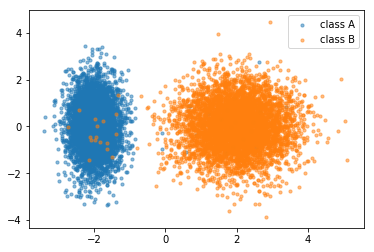

In [21]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=10, alpha=0.5, label='class A')
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=10, alpha=0.5, label='class B')
plt.legend(loc='upper right')

plt.savefig('dataset_generated')
plt.show()

In [22]:
X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)

In [23]:
y_train = np.zeros(len(X_train))
y_test = np.ones(len(X_test))

X_all = np.concatenate([X_train, X_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

In [39]:
X_train_adv, X_valid_adv, y_train_adv, y_valid_adv = \
    train_test_split(X_all, y_all, test_size=0.33, random_state=42, shuffle=True)

model = lgb.LGBMClassifier(
    n_estimators=1000,
    random_state=42)

model.fit(
    X_train_adv,
    y_train_adv,
    eval_set=[(X_train_adv, y_train_adv), (X_valid_adv, y_valid_adv)],
    eval_names=['train', 'valid'],
    eval_metric='auc',
    verbose=100)

[100]	train's auc: 0.782076	train's binary_logloss: 0.557127	valid's auc: 0.497288	valid's binary_logloss: 0.657668
[200]	train's auc: 0.827369	train's binary_logloss: 0.51758	valid's auc: 0.494975	valid's binary_logloss: 0.679498
[300]	train's auc: 0.855182	train's binary_logloss: 0.490556	valid's auc: 0.497956	valid's binary_logloss: 0.693934
[400]	train's auc: 0.874698	train's binary_logloss: 0.467877	valid's auc: 0.497067	valid's binary_logloss: 0.710681
[500]	train's auc: 0.889346	train's binary_logloss: 0.449332	valid's auc: 0.496517	valid's binary_logloss: 0.724091
[600]	train's auc: 0.901977	train's binary_logloss: 0.432418	valid's auc: 0.496636	valid's binary_logloss: 0.737013
[700]	train's auc: 0.912475	train's binary_logloss: 0.417466	valid's auc: 0.496348	valid's binary_logloss: 0.748054
[800]	train's auc: 0.921786	train's binary_logloss: 0.404721	valid's auc: 0.498344	valid's binary_logloss: 0.757607
[900]	train's auc: 0.92909	train's binary_logloss: 0.392674	valid's auc: 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

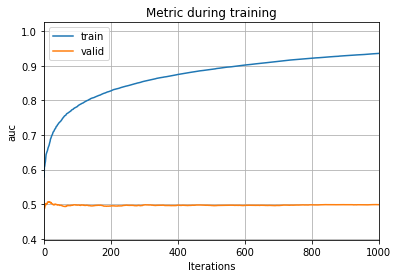

In [40]:
ax = lgb.plot_metric(model.evals_result_, metric='auc')
plt.savefig('learning_curve_identical_dataset')
plt.show()

In [44]:
sample_submission = pd.read_csv("../input/data-science-bowl-2019/sample_submission.csv")
specs = pd.read_csv("../input/data-science-bowl-2019/specs.csv")
test = pd.read_csv("../input/data-science-bowl-2019/test.csv")
train = pd.read_csv("../input/data-science-bowl-2019/train.csv")
train_labels = pd.read_csv("../input/data-science-bowl-2019/train_labels.csv")

In [45]:
def get_data(user_sample, test_set=False):
    all_assessments = []
    type_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    for i, session in user_sample.groupby('game_session', sort=False):
        session_title = session['title'].iloc[0]
        session_type = session['type'].iloc[0]
        
        if (session_type == 'Assessment') and (test_set or len(session) > 1):
            event_code = 4110 if session_title == 'Bird Measurer (Assessment)' else 4100
            all_attempts = session.query(f'event_code == {event_code}')
            num_correct = all_attempts['event_data'].str.contains('true').sum()
            num_incorrect = all_attempts['event_data'].str.contains('false').sum()
            
            features = {}
            features['installation_id'] = session['installation_id'].iloc[-1]
            features['title'] = session_title
            features['num_correct_attempts'] = num_correct
            
            features.update(type_count.copy())
            
            if test_set:
                all_assessments.append(features)
            elif num_correct + num_incorrect > 0:
                all_assessments.append(features)
    
        type_count[session_type] += 1
    
    if test_set:
        return all_assessments[-1]
    
    return all_assessments

In [46]:
compiled_train = []
for ins_id, user_sample in tqdm(train.groupby('installation_id', sort=False), total=17000):
    compiled_train += get_data(user_sample)

compiled_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
    test_data = get_data(user_sample, test_set=True)
    compiled_test.append(test_data)

X_train = pd.DataFrame(compiled_train)
X_test = pd.DataFrame(compiled_test)

In [47]:
display(X_train.head())
display(X_test.head())

,installation_id,title,num_correct_attempts,Clip,Activity,Assessment,Game
0,0006a69f,Mushroom Sorter (Assessment),1,11,3,0,4
1,0006a69f,Bird Measurer (Assessment),0,14,4,1,6
2,0006a69f,Mushroom Sorter (Assessment),1,14,4,2,6
3,0006a69f,Mushroom Sorter (Assessment),1,24,9,4,10
4,0006a69f,Bird Measurer (Assessment),1,28,10,5,13


,installation_id,title,num_correct_attempts,Clip,Activity,Assessment,Game
0,00abaee7,Cauldron Filler (Assessment),0,14,7,1,3
1,01242218,Cart Balancer (Assessment),0,29,11,5,12
2,017c5718,Mushroom Sorter (Assessment),0,6,2,0,0
3,01a44906,Mushroom Sorter (Assessment),0,10,2,0,1
4,01bc6cb6,Cart Balancer (Assessment),0,17,1,0,6


In [48]:
X_train = X_train.drop(['installation_id'], axis=1)
X_test = X_test.drop(['installation_id'], axis=1)

le = LabelEncoder()
le.fit(list(X_train['title'].values) + list(X_test['title'].values))
X_train['title'] = le.transform(list(X_train['title'].values))
X_test['title'] = le.transform(list(X_test['title'].values))

In [49]:
X_train['adv_target'] = 0
X_test['adv_target'] = 1
train_test_adv = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

train_adv, valid_adv = train_test_split(train_test_adv, test_size=0.33, random_state=42)
X_train_adv = train_adv.drop(['adv_target'], axis=1)
y_train_adv = train_adv['adv_target']
X_valid_adv = valid_adv.drop(['adv_target'], axis=1)
y_valid_adv = valid_adv['adv_target']

model = lgb.LGBMClassifier(
    n_estimators=1000,
    random_state=42)

model.fit(
    X_train_adv,
    y_train_adv,
    eval_set=[(X_train_adv, y_train_adv), (X_valid_adv, y_valid_adv)],
    eval_names=['train', 'valid'],
    eval_metric='auc',
    verbose=100)

[100]	train's auc: 0.984175	train's binary_logloss: 0.0782951	valid's auc: 0.944309	valid's binary_logloss: 0.11996
[200]	train's auc: 0.992286	train's binary_logloss: 0.0610731	valid's auc: 0.943027	valid's binary_logloss: 0.129427
[300]	train's auc: 0.995545	train's binary_logloss: 0.0494579	valid's auc: 0.941932	valid's binary_logloss: 0.138353
[400]	train's auc: 0.996907	train's binary_logloss: 0.0418042	valid's auc: 0.940518	valid's binary_logloss: 0.150349
[500]	train's auc: 0.997699	train's binary_logloss: 0.0359004	valid's auc: 0.938413	valid's binary_logloss: 0.162301
[600]	train's auc: 0.998227	train's binary_logloss: 0.0310913	valid's auc: 0.936735	valid's binary_logloss: 0.173514
[700]	train's auc: 0.998426	train's binary_logloss: 0.0283546	valid's auc: 0.935516	valid's binary_logloss: 0.187687
[800]	train's auc: 0.998596	train's binary_logloss: 0.0259364	valid's auc: 0.935128	valid's binary_logloss: 0.19857
[900]	train's auc: 0.998706	train's binary_logloss: 0.0239087	vali

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

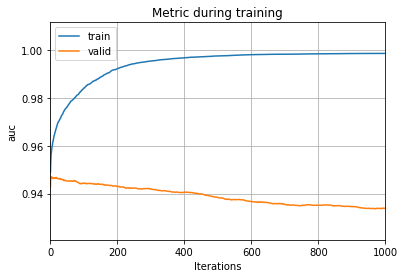

In [50]:
ax = lgb.plot_metric(model.evals_result_, metric='auc')
plt.savefig('learning_curve_with_leaky_feature')
plt.show()

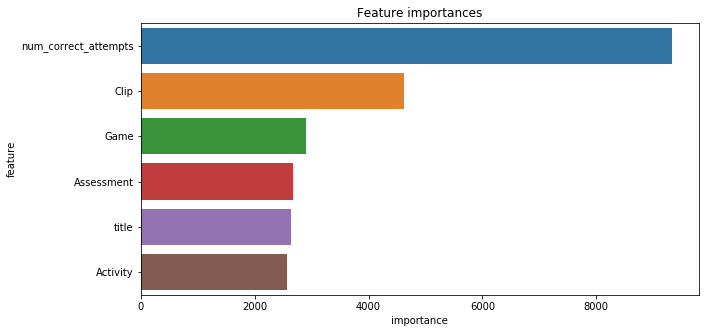

In [51]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = X_train_adv.columns
feature_importance['importance'] = model.booster_.feature_importance(importance_type='gain')
feature_importance = feature_importance.sort_values(by='importance', ascending=False).reset_index().iloc[:10]

plt.figure(figsize=(10,5))
sns.barplot(data=feature_importance, x='importance', y='feature', orient='h')
plt.title('Feature importances')
plt.savefig('feaure_importance_with_leaky_feature')

In [52]:
new_X_train_adv = train_adv.drop(['num_correct_attempts'], axis=1)
new_X_valid_adv = valid_adv.drop(['num_correct_attempts'], axis=1)

model = lgb.LGBMClassifier(
    n_estimators=2000,
    random_state=42)

model.fit(
    X_train_adv,
    y_train_adv,
    eval_set=[(new_X_train_adv, y_train_adv), (new_X_valid_adv, y_valid_adv)],
    eval_names=['train', 'valid'],
    eval_metric='auc',
    verbose=100)

[100]	train's auc: 0.56146	train's binary_logloss: 0.623939	valid's auc: 0.579143	valid's binary_logloss: 0.596806
[200]	train's auc: 0.614855	train's binary_logloss: 0.668891	valid's auc: 0.628241	valid's binary_logloss: 0.63933
[300]	train's auc: 0.626653	train's binary_logloss: 0.710895	valid's auc: 0.631347	valid's binary_logloss: 0.680477
[400]	train's auc: 0.6269	train's binary_logloss: 0.751213	valid's auc: 0.629878	valid's binary_logloss: 0.718943
[500]	train's auc: 0.648883	train's binary_logloss: 0.792129	valid's auc: 0.649837	valid's binary_logloss: 0.760487
[600]	train's auc: 0.650243	train's binary_logloss: 0.809698	valid's auc: 0.655001	valid's binary_logloss: 0.775922
[700]	train's auc: 0.645408	train's binary_logloss: 0.879938	valid's auc: 0.652181	valid's binary_logloss: 0.843521
[800]	train's auc: 0.639443	train's binary_logloss: 0.930262	valid's auc: 0.647854	valid's binary_logloss: 0.891309
[900]	train's auc: 0.655232	train's binary_logloss: 0.967222	valid's auc: 0.

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=2000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

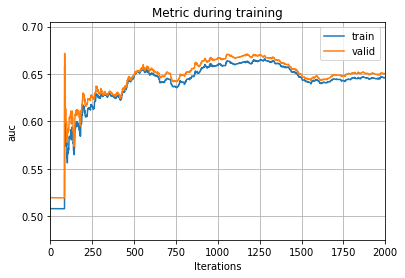

In [53]:
ax = lgb.plot_metric(model.evals_result_, metric='auc')
plt.savefig('learning_curve_without_leaky_feature')
plt.show()

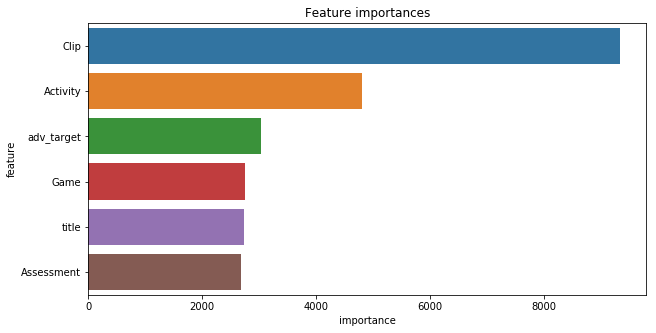

In [54]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = new_X_train_adv.columns
feature_importance['importance'] = model.booster_.feature_importance(importance_type='gain')
feature_importance = feature_importance.sort_values(by='importance', ascending=False).reset_index().iloc[:10]

plt.figure(figsize=(10,5))
sns.barplot(data=feature_importance, x='importance', y='feature', orient='h')
plt.title('Feature importances')
plt.savefig('feature_importance_without_leaky_feature')